## Experimentation with Random Fourier Features

In [1]:
import numpy as np

#solve for alpha st.
#e^(-alpha * context ^ 2) = thresh

context = 256
thresh = 0.1
alpha = -np.log(thresh) / (context ** 2)
print(alpha)

3.5134660232453086e-05


In [4]:
def rff_embedding(N, K, alpha):
    """
    Generate RFF-based embedding for integer `n` using `K` dimensions.
    Parameters:
        N (list<int>): list of integers
        K (int): Embedding dimension.
        alpha (float): Gaussian kernel decay parameter.
    Returns:
        np.ndarray: K-dimensional embedding.
    """
    M = K // 2  # Use K/2 pairs of cos and sin
    # Sample frequencies (w) from N(0, 2*alpha)
    w = np.random.normal(0, np.sqrt(2 * alpha), M)
    # Sample random phases (b) from Uniform(0, 2*pi)
    b = np.random.uniform(0, 2 * np.pi, M)
    # Compute embedding using cos(w * n + b) and sin(w * n + b)
    N = np.array(N)
    embedding = np.sqrt(2 / K) * np.concatenate([
        np.cos(np.outer(N, w) + b),
        np.sin(np.outer(N, w) + b)
    ], axis=1)
    return embedding

N = [i for i in range(0, 10_000, 100)]
K = 2048
embeds = rff_embedding(N, K, alpha)
print(embeds.shape)

(100, 2048)


In [3]:
import torch

def encode(positions, K, alpha) -> torch.Tensor:
    """
    Generate RFF-based embeddings using PyTorch for integer positions.
    Parameters:
        positions (torch.Tensor): integer tensor of shape (...), e.g., (B, T)
    Returns:
        torch.Tensor: embeddings of shape (..., K) where K == embed_dim
    """
    M = K // 2  # Use K/2 pairs of cos and sin
    device = positions.device
    dtype = torch.float32

    # Sample frequencies (w) ~ N(0, sqrt(2*alpha)) and phases (b) ~ Uniform(0, 2*pi)
    w = torch.randn(M, device=device) * (2.0 * alpha) ** 0.5
    b = torch.rand(M, device=device) * (2.0 * torch.pi)

    # Compute embedding using cos(w * n + b) and sin(w * n + b)
    pos = positions.to(dtype)
    z = pos[..., None] * w + b  # (..., M)
    cos_z = torch.cos(z)
    sin_z = torch.sin(z)
    embedding = torch.cat([cos_z, sin_z], dim=-1)  # (..., K)
    embedding = embedding * (2.0 / float(K)) ** 0.5
    return embedding

N = torch.arange(0, 10_000, 100)
K = 2048
embeds = encode(N, K, alpha)
print(embeds.shape)

torch.Size([100, 2048])


torch.Size([100, 100])


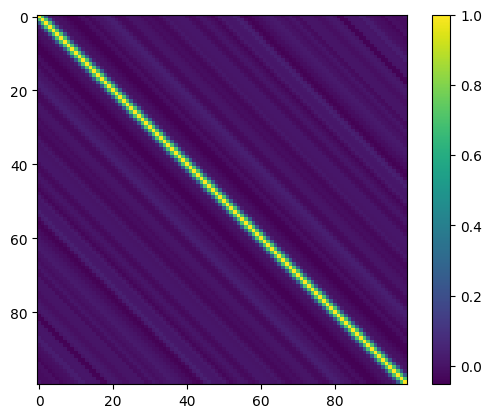

In [4]:
#compute similarities
similarities = embeds @ embeds.T
print(similarities.shape)

from matplotlib import pyplot as plt
plt.imshow(similarities)
plt.colorbar()
plt.show()

(2001,)
(2001,)


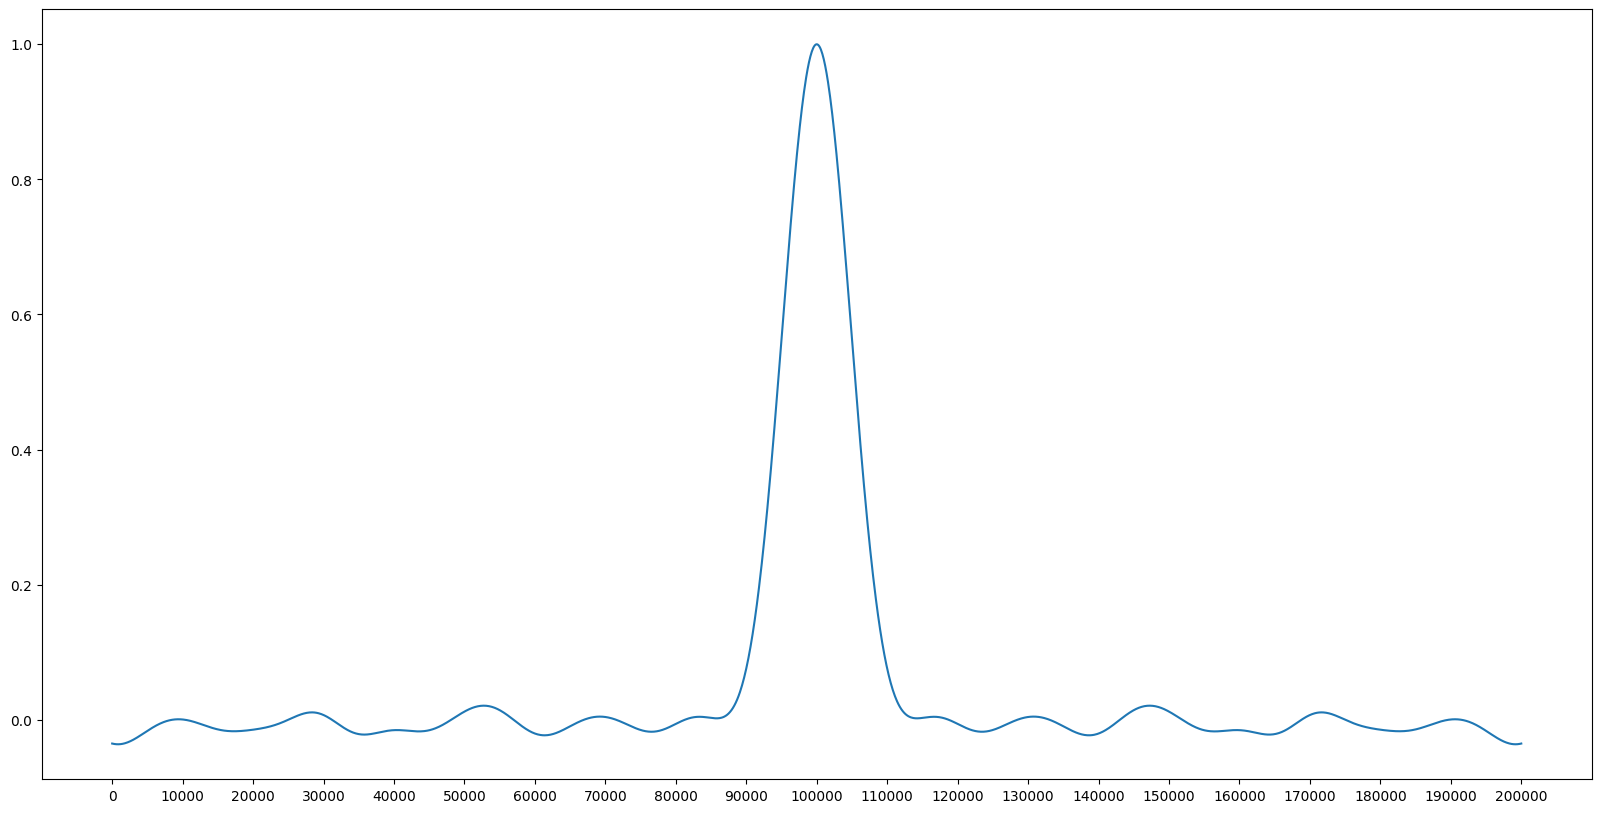

In [122]:
N = [i for i in range(0, 200_001, 100)]
embeds = rff_embedding(N, K, alpha)
chosen = embeds[len(N)//2]

similarities = embeds @ chosen.T
print(similarities.shape)

similarities = similarities.flatten()
print(similarities.shape)

from matplotlib import pyplot as plt
plt.figure(figsize=(20, 10))
plt.plot(similarities)
#set X axis to be the same as N
locations = range(0, len(N), 100)
plt.xticks(locations, [N[i] for i in locations])
plt.show()